In [1]:
import tensorflow as tf
from tensorflow import keras

2024-03-20 02:15:18.482211: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-20 02:15:18.663194: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-20 02:15:18.663210: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-03-20 02:15:18.698517: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-20 02:15:19.614454: W tensorflow/stream_executor/platform/de

In [2]:
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import os
from sklearn.metrics import f1_score, precision_score


In [3]:
df=pd.read_csv(os.path.join(os.getcwd(), "..", "data",'eurousd.csv'))
df.head()

,date,time,open,high,low,close,volume
0,21/10/2002,01:05:00,0.97320,0.97325,0.97280,0.97285,0
1,21/10/2002,01:10:00,0.97300,0.97320,0.97300,0.97320,0
2,21/10/2002,01:15:00,0.97320,0.97320,0.97295,0.97310,0
3,21/10/2002,01:20:00,0.97315,0.97340,0.97270,0.97270,0
4,21/10/2002,01:25:00,0.97280,0.97295,0.97260,0.97260,0


In [4]:
df['date']=pd.to_datetime(df['date'])
df=df[df['date'].dt.year>2022]
df.set_index(['date'])
df['diff']=df['close'].diff()
df['dir']=df['diff'].apply(lambda x: 1 if x >0 else 0)
df.head()

/tmp/ipykernel_338025/2620813244.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['date']=pd.to_datetime(df['date'])


,date,time,open,high,low,close,volume,diff,dir
1530509,2023-01-01,18:00:00,1.07037,1.07042,1.07037,1.07042,5,NaN,0
1530510,2023-01-01,18:05:00,1.07043,1.07046,1.07043,1.07046,4,0.00004,1
1530511,2023-01-01,18:10:00,1.07047,1.07053,1.07047,1.07052,6,0.00006,1
1530512,2023-01-01,18:15:00,1.07048,1.07048,1.07028,1.07028,7,-0.00024,0
1530513,2023-01-01,18:20:00,1.07025,1.07025,1.07007,1.07007,10,-0.00021,0


In [5]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from datetime import datetime

def create_dataset(data, T, D):
  X, y = [], []
  for i in range(T, len(data)):
    X.append(data[ 'close'].iloc[i-T:i].to_numpy())
    y.append(data['dir'].iloc[i])
  return np.array(X), np.array(y)


In [ ]:
class_counts = df['dir'].value_counts()

# Determine majority and minority classes
majority_class = class_counts.idxmax()
minority_class = class_counts.idxmin()

# Calculate class weight ratio
class_weight_ratio = class_counts[majority_class] / class_counts[minority_class]

# Print the class weight ratio
print(f"Class weight ratio: {class_weight_ratio:.2f}")

In [ ]:
def weighted_binary_crossentropy(y_true, y_pred, class_weight):
  """
  Custom binary crossentropy loss function with class weights.

  Args:
      y_true: True labels (0 or 1).
      y_pred: Predicted probabilities.
      class_weight: Weight for the minority class.

  Returns:
      Weighted binary crossentropy loss.
  """
  # Clip predictions to avoid overflow (optional)
  y_pred = tf.clip_by_value(y_pred, eps=1e-7, clip_value_max=1-eps)
  # Calculate binary crossentropy loss
  bce = tf.nn.binary_crossentropy(y_true, y_pred)
  # Apply class weight
  weighted_bce = bce * class_weight
  # Return the mean weighted loss
  return tf.reduce_mean(weighted_bce)


In [6]:
data=df
T = 10
D = 1


split1 = int(len(data) * 0.7)
split2 = int(len(data) * 0.9)

data_train = data[:split1]
data_val = data[split1:split2]
data_test = data[split2:]

In [7]:
X_train, y_train = create_dataset(data_train, T, D)
X_val, y_val = create_dataset(data_val, T, D)
X_test, y_test = create_dataset(data_test, T, D)

In [8]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(T, D)))
#model.add(keras.layers.Dropout(0.2))
Dense(10, activation='relu')
model.add(Dense(1, activation='sigmoid'))
# Compile the model
model.compile(loss=weighted_binary_crossentropy(class_weight_ratio), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


2024-03-20 02:15:29.895357: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-20 02:15:29.895508: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-20 02:15:29.895585: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-03-20 02:15:29.895660: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-03-20 02:15:29.895730: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [9]:
history= model.fit(X_train, y_train, epochs=30
                   , batch_size=32, validation_data=(X_val, y_val), verbose=1)

Epoch 1/30
1974/1974 [==============================] - 28s 13ms/step - loss: 0.6934 - accuracy: 0.5023 - val_loss: 0.6930 - val_accuracy: 0.5104
Epoch 2/30
1974/1974 [==============================] - 25s 13ms/step - loss: 0.6932 - accuracy: 0.5070 - val_loss: 0.6930 - val_accuracy: 0.5104
Epoch 3/30
1974/1974 [==============================] - 25s 13ms/step - loss: 0.6931 - accuracy: 0.5047 - val_loss: 0.6930 - val_accuracy: 0.5104
Epoch 4/30
1974/1974 [==============================] - 25s 13ms/step - loss: 0.6931 - accuracy: 0.5073 - val_loss: 0.6930 - val_accuracy: 0.5104
Epoch 5/30
1974/1974 [==============================] - 28s 14ms/step - loss: 0.6931 - accuracy: 0.5079 - val_loss: 0.6930 - val_accuracy: 0.5104
Epoch 6/30
1974/1974 [==============================] - 26s 13ms/step - loss: 0.6931 - accuracy: 0.5082 - val_loss: 0.6930 - val_accuracy: 0.5104
Epoch 7/30
1974/1974 [==============================] - 25s 13ms/step - loss: 0.6930 - accuracy: 0.5089 - val_loss: 0.6931 -

KeyboardInterrupt: 

In [ ]:
predictions = model.predict(X_test)

282/282 [==============================] - 2s 4ms/step


In [ ]:
print("Predictions:", predictions)

Predictions: [[0.48887384]
 [0.48887378]
 [0.48887384]
 ...
 [0.48886627]
 [0.4888664 ]
 [0.4888663 ]]


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
df2=pd.DataFrame(predictions, y_test)
df2

,0
0,0.488874
0,0.488874
1,0.488874
1,0.488874
1,0.488874
...,...
1,0.488866
1,0.488866
0,0.488866
1,0.488866


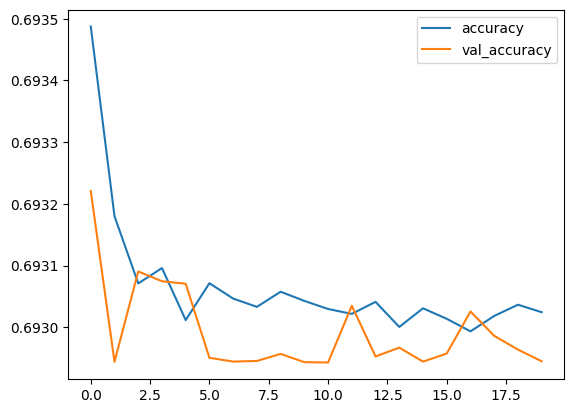

In [ ]:
plt.plot(history.history['loss'], label='accuracy')
plt.plot(history.history['val_loss'], label='val_accuracy')
plt.legend()
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

282/282 [==============================] - 1s 5ms/step - loss: 0.6928 - accuracy: 0.5144


[0.6927555799484253, 0.5143649578094482]

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
#df=df.set_index('date')
df


,date,time,open,high,low,close,volume,diff,dir
1530509,2023-01-01,18:00:00,1.07037,1.07042,1.07037,1.07042,5,NaN,0
1530510,2023-01-01,18:05:00,1.07043,1.07046,1.07043,1.07046,4,0.00004,1
1530511,2023-01-01,18:10:00,1.07047,1.07053,1.07047,1.07052,6,0.00006,1
1530512,2023-01-01,18:15:00,1.07048,1.07048,1.07028,1.07028,7,-0.00024,0
1530513,2023-01-01,18:20:00,1.07025,1.07025,1.07007,1.07007,10,-0.00021,0
...,...,...,...,...,...,...,...,...,...
1620745,2024-03-14,20:25:00,1.08767,1.08781,1.08767,1.08773,391,0.00007,1
1620746,2024-03-14,20:30:00,1.08773,1.08784,1.08773,1.08782,382,0.00009,1
1620747,2024-03-14,20:35:00,1.08781,1.08782,1.08768,1.08774,394,-0.00008,0
1620748,2024-03-14,20:40:00,1.08774,1.08782,1.08761,1.08781,444,0.00007,1


In [ ]:

plt.plot(df.indexy_train)


AttributeError: 'DataFrame' object has no attribute 'indexy_train'

In [ ]:
date_index = pd.to_datetime(data_test.index)

plt.plot(data_train.index[T:], y_train, marker='o', label='Training Data')
plt.plot(data_val.index[T:], y_val, marker='o', label='Validation Data')

plt.plot(data_test.index[T:], y_test, marker='o', label='Test Data')


plt.plot(data_test.index[T:], predictions, marker='x', label='Predictions')

plt.xlabel('date')
plt.ylabel('Closing Price')
plt.title('Price Prediction (LSTM)')
plt.legend()
plt.show()

In [ ]:
lstm2=model.evaluate(X_test, y_test)